<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

Se realizó con embeddings propios y con embeddings Fasttext. 
En este trabajo se presenta la arquitectura con la que fue posible obtener la mejor performance. Aunque ello no implica que hayan sido buenos. Sino más bien todo lo contrario. En ambos casos se ensayó:
- Cambiando la cantidad de capas y neuronas.
- Cantidad de épocas. 


Al final se mencionan las conclusiones de los resultados obtenidos

In [91]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [92]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [93]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [94]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [95]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [96]:
# Observación de balanceo de clase
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

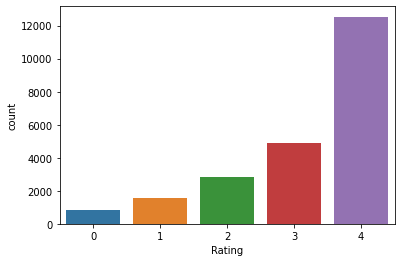

In [97]:
# Gráfica de balanceo de clases
sns.countplot(x='Rating', data=df_reviews)
plt.show()

El dataset está claramente desbalanceado. Esto implica que deberá emmplearse algún método de balanceo al momento de realizar el _split_ de datos.

In [98]:
# Columna de las review almacenada en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [99]:
# Cantidad de reviews para evaluar
len(text_sequences)

22641

In [100]:
# Concatenado de todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [101]:
# Longitud del corpus
len(corpus)

7011643

In [102]:
# Utilización de "text_to_word_sequence" para separar las palabras en tokens
# text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [103]:
# Vista de los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [104]:
# Cantidad de tokens/palabra
len(tokens)

1372203

In [105]:
# Tokenizado de las palabras con el Tokenizer de Keras
# Definición una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words)
tok.fit_on_texts(tokens)

In [106]:
# Obtención del diccionario de palabra (word) a índice
# y observación de la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [107]:
# Converción de las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [108]:
sequences[1][:10]

[21, 7, 18, 33, 1713, 99, 2, 1322, 8, 221]

In [109]:
# Oración más larga
max(len(s) for s in sequences)

115

In [110]:
# Realización del padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = max(len(s) for s in sequences)
 
# Realización de padding para obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [111]:
# Observación de las dimensiones de la variable input
X.shape

(22641, 115)

In [112]:
# Se tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

In [113]:
# División de los datos en train y test
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
rng = np.random.RandomState(1)

#Separación del set de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y, shuffle=True)

# Balanceo de los set train empleando imbalanced learning, método "smote"
sm = SMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

In [114]:
# Verificación de las dimensiones de los set de datos train y test
print('Set entrenamiento "X" balanceado:', X_train_os.shape)
print('Testeo "X":',X_test.shape)
print('\n')
print('Set entrenamiento "y" balanceado:', y_train_os.shape)
print('Testeo "y":', y_test.shape)


Set entrenamiento "X" balanceado: (50160, 115)
Testeo "X": (4529, 115)


Set entrenamiento "y" balanceado: (50160,)
Testeo "y": (4529,)


In [115]:
# Verificación de balanceo
np.bincount(y_train_os)

array([10032, 10032, 10032, 10032, 10032])

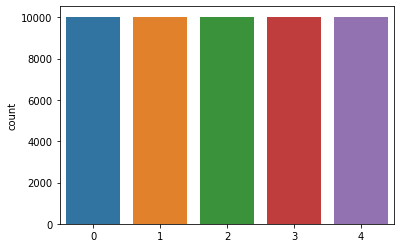

In [116]:
# Visualización gráfica de cómo ha quedado el balanceo
sns.countplot(x=y_train_os)
plt.show()

In [122]:
# Transformación de los set "y" balanceados a One Hot Encoding
y_train_ohe = to_categorical(y_train_os).astype('int')
y_test_ohe = to_categorical(y_test).astype('int')

In [118]:
# Verificación de las dimensiones de los set "y" balanceados y transformados a OHE
# Debe expresarse la cantidad de clases = 5
print('Set entrenamiento "y" balanceado:', y_train_ohe.shape)
print('Testeo "y":', y_test_ohe.shape)

Set entrenamiento "y" balanceado: (50160, 5)
Testeo "y": (4529, 5)


In [127]:
# Determinación de la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = y_test_ohe.shape[1] # binary classification
print("in_shape:", in_shape, ", out_shape:", out_shape)

in_shape: 115 , out_shape: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [182]:
# Entrenamiento de modelo con LSTM entrenando embeddings propios
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a la sequencia más larga
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(64, activation='relu'))

model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 115, 50)           100050    
                                                                 
 lstm_35 (LSTM)              (None, 115, 128)          91648     
                                                                 
 dropout_23 (Dropout)        (None, 115, 128)          0         
                                                                 
 lstm_36 (LSTM)              (None, 115, 128)          131584    
                                                                 
 dropout_24 (Dropout)        (None, 115, 128)          0         
                                                                 
 lstm_37 (LSTM)              (None, 115, 64)           49408     
                                                                 
 dropout_25 (Dropout)        (None, 115, 64)         

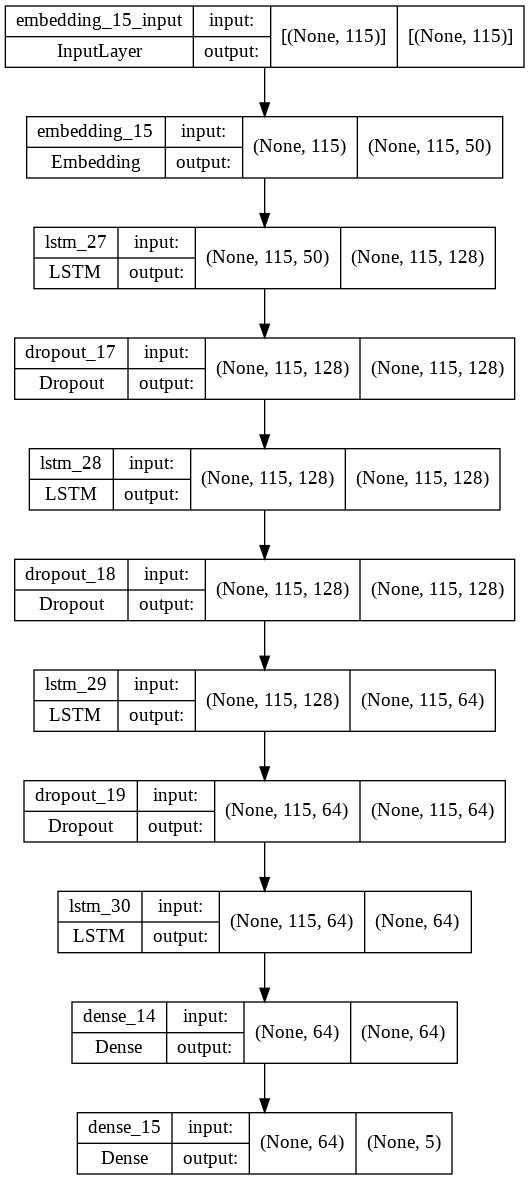

In [177]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [183]:
hist = model.fit(X_train_os, y_train_ohe, epochs=70, validation_split=0.2)

Epoch 1/70
1254/1254 [==============================] - 40s 26ms/step - loss: 1.1904 - accuracy: 0.4485 - val_loss: 4.1868 - val_accuracy: 0.0020
Epoch 2/70
1254/1254 [==============================] - 33s 26ms/step - loss: 1.0124 - accuracy: 0.5093 - val_loss: 4.7439 - val_accuracy: 0.0016
Epoch 3/70
1254/1254 [==============================] - 32s 25ms/step - loss: 0.9701 - accuracy: 0.5276 - val_loss: 4.4628 - val_accuracy: 3.9872e-04
Epoch 4/70
1254/1254 [==============================] - 32s 26ms/step - loss: 0.9516 - accuracy: 0.5291 - val_loss: 5.1968 - val_accuracy: 0.0028
Epoch 5/70
1254/1254 [==============================] - 33s 26ms/step - loss: 0.9290 - accuracy: 0.5382 - val_loss: 5.1345 - val_accuracy: 0.0040
Epoch 6/70
1254/1254 [==============================] - 32s 25ms/step - loss: 0.9140 - accuracy: 0.5476 - val_loss: 4.8627 - val_accuracy: 0.0047
Epoch 7/70
1254/1254 [==============================] - 32s 26ms/step - loss: 0.9000 - accuracy: 0.5549 - val_loss: 5.39

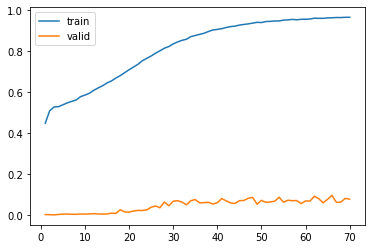

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

La performance es muy mala si se considera que se entrena el modelo para pasar a una fase de producción. Se produce overfitting.

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM
Se prueba emplear embeddings Fasttext para ver si mejora el modelo.

In [140]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:47<00:00, 60.3MB/s]


In [161]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [162]:
model_fasttext = FasttextEmbeddings()

In [163]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [164]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)       # marcar como layer no entrenable

In [178]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(64, activation='relu'))

model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 115, 300)          600000    
                                                                 
 lstm_31 (LSTM)              (None, 115, 128)          219648    
                                                                 
 dropout_20 (Dropout)        (None, 115, 128)          0         
                                                                 
 lstm_32 (LSTM)              (None, 115, 128)          131584    
                                                                 
 dropout_21 (Dropout)        (None, 115, 128)          0         
                                                                 
 lstm_33 (LSTM)              (None, 115, 64)           49408     
                                                                 
 dropout_22 (Dropout)        (None, 115, 64)         

In [179]:
hist2 = model2.fit(X_train_os, y_train_ohe, epochs=50, validation_split=0.2)

Epoch 1/50
1254/1254 [==============================] - 39s 27ms/step - loss: 1.4000 - accuracy: 0.3745 - val_loss: 3.5192 - val_accuracy: 0.0000e+00
Epoch 2/50
1254/1254 [==============================] - 32s 25ms/step - loss: 1.2159 - accuracy: 0.4447 - val_loss: 3.9576 - val_accuracy: 1.9936e-04
Epoch 3/50
1254/1254 [==============================] - 32s 26ms/step - loss: 1.1805 - accuracy: 0.4532 - val_loss: 4.2572 - val_accuracy: 3.9872e-04
Epoch 4/50
1254/1254 [==============================] - 32s 25ms/step - loss: 1.1514 - accuracy: 0.4661 - val_loss: 4.4171 - val_accuracy: 0.0015
Epoch 5/50
1254/1254 [==============================] - 33s 26ms/step - loss: 1.1288 - accuracy: 0.4738 - val_loss: 4.8822 - val_accuracy: 0.0020
Epoch 6/50
1254/1254 [==============================] - 32s 26ms/step - loss: 1.1046 - accuracy: 0.4831 - val_loss: 5.0014 - val_accuracy: 0.0056
Epoch 7/50
1254/1254 [==============================] - 32s 26ms/step - loss: 1.0838 - accuracy: 0.4908 - val_lo

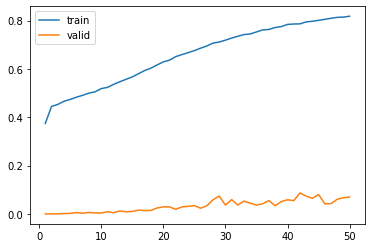

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

### Conclusiones
Hasta donde se pudo evaluar, ambos modelos no fueron buenos. Al incrementar la cantidad de épocas, empezó a mostrar variaciones la validación del entrenamiento, con una apenas perceptible mejor performance para el caso de Fasttext. Pero claramente estos modelos así como están configurados no son buenos. 